In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Load the CSV file
df = pd.read_csv("graph_edge_list (3).csv")

In [3]:
# Create a directed graph (since requirements have a direction)
G = nx.DiGraph()

In [4]:
print (G)

DiGraph with 0 nodes and 0 edges


In [5]:
# Add edges to the graph
if 'START' not in G.nodes:
    G.add_node('START')

for _, row in df.iterrows():
    source = row['Source']
    target = row['target']
    weight = row['weight']
    G.add_edge(source, target, weight=weight)

In [6]:
# Display basic graph information
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 90
Number of edges: 144


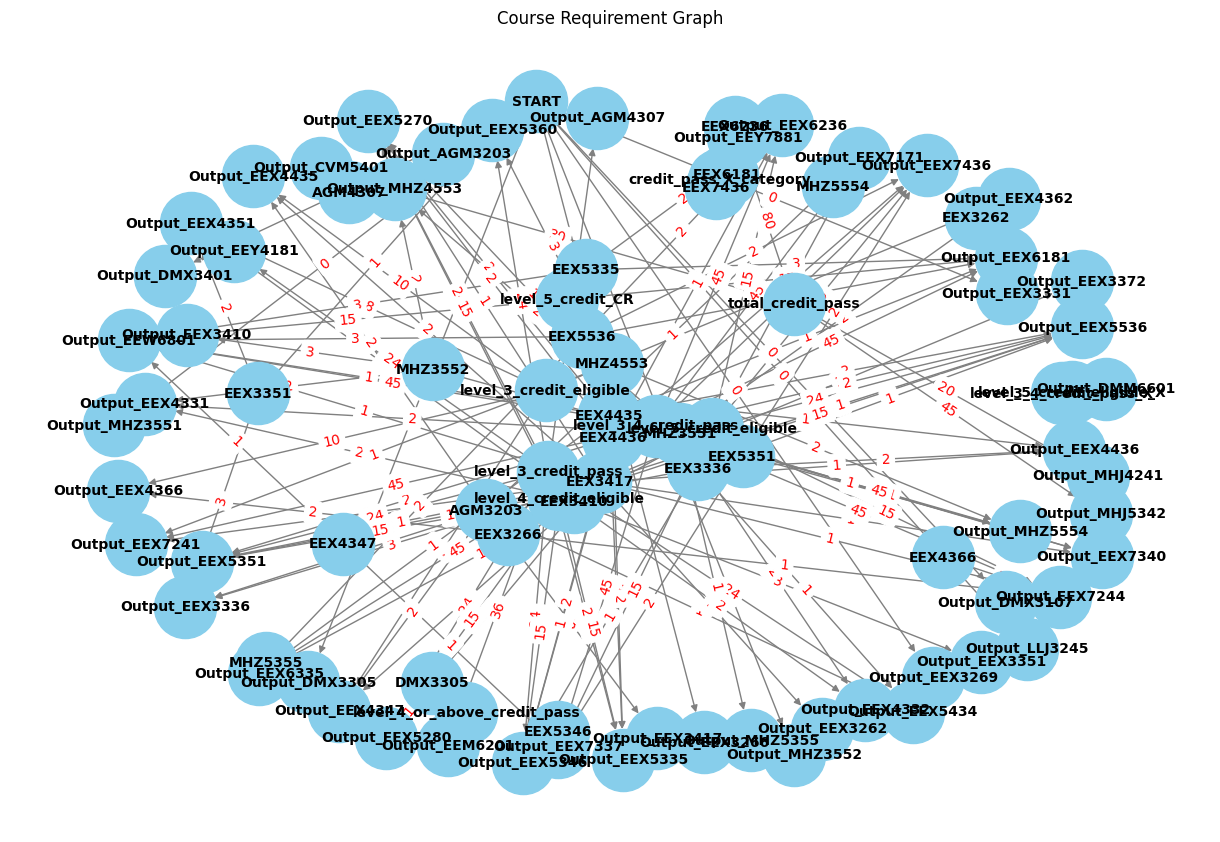

In [7]:
# Visualize the graph using Matplotlib
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("Course Requirement Graph")
plt.show()

In [8]:
# Load the dataset
results_data = pd.read_excel("/content/BT_computerStudent_Results_from2019V2 (1).xlsx")


In [9]:
# List of course codes to keep
course_codes = [
    "AGM3203", "EEX3331", "EEX3336", "EEX3351", "EEX3410", "EEX3417", "DMX3401", "DMX3304", "DMX3305",
    "MHZ3551", "MHZ3552", "EEX3266", "EEX3269", "EEX3262", "AGM4307", "DMX3107", "EEX4331", "EEX4332",
    "EEX4435", "EEX4347", "EEX4436", "EEX4351", "EEY4181", "MHZ4553", "MHZ5355", "EEX3372", "EEX4362",
    "EEX4366", "LLJ3245", "MHJ4241", "CVM5401", "EEX5270", "EEX5434", "EEX5335", "EEX5536", "EEX5346",
    "EEX5351", "EEX6181", "MHZ5554", "EEW6801", "MHJ5342", "EEX5360", "EEX6335", "EEX6236", "DMM6601",
    "EEM6201", "EEX7436", "EEX7337", "EEY7881", "EEX5280", "EEX7241", "EEX7244", "EEX7340", "EEX7171"
]

In [10]:
# Filter the DataFrame
df_filtered = results_data[results_data['Cou_Code'].isin(course_codes)]

In [11]:
# Define a function to assign the numbers based on Pst_Text
def assign_status(status):
    if status == 'Pass' or status == 'Exempted':
        return 1  # Pass or Exempted
    elif status == 'Repeat':
        return 0  # Fail
    elif status == 'Resit':
        return 2  # Eligible
    elif status == 'Pending':
        return 3  # Pending
    else:
        return None  # Handle any unexpected values

In [12]:
# Apply the function to the Pst_Text column
df_filtered['Status_Code'] = df_filtered['Pst_Text'].apply(assign_status)

<ipython-input-12-7c2f7d7abf2e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Status_Code'] = df_filtered['Pst_Text'].apply(assign_status)


In [13]:
# Save the updated dataset to a new CSV file (optional)
df_filtered.to_csv('updated_dataset.csv', index=False)

In [14]:
# Load the updated dataset
Updated_df = pd.read_csv("updated_dataset.csv")

In [15]:
def generate_input_output_cumulative(df):
    records = []
    for app_id, group in df.groupby('ApplicationID'):
        years = sorted(group['CourseOfferdAcYear'].dropna().unique())  # Sorted list of years

        cumulative_input_courses = pd.DataFrame(columns=['Cou_Code', 'Status_Code'])

        for i in range(len(years) - 1):
            input_year = years[i]
            output_year = years[i + 1]

            # Add current year's input courses to cumulative input
            current_input = group[group['CourseOfferdAcYear'] == input_year][['Cou_Code', 'Status_Code']]
            cumulative_input_courses = pd.concat([cumulative_input_courses, current_input])

            # Output courses only from the next year
            output_courses = group[group['CourseOfferdAcYear'] == output_year]['Cou_Code']

            # Build input and output dictionaries
            input_dict = {course: status for course, status in zip(cumulative_input_courses['Cou_Code'], cumulative_input_courses['Status_Code'])}
            output_dict = {course: 1 for course in output_courses}

            # Create record
            record = {
                'ApplicationID': app_id,
                'Input_years': '+'.join(map(str, years[:i+1])),
                'Output_Year': output_year
            }

            # Add inputs
            for course in course_codes:
                record[course] = input_dict.get(course, 0)

            # Add outputs
            for course in course_codes:
                record[f'Output_{course}'] = output_dict.get(course, 0)

            records.append(record)

    return pd.DataFrame(records)


In [16]:
# Generate the new dataset
new_df = generate_input_output_cumulative(Updated_df)

In [17]:
# Save the new dataset
output_path = '/content/prepared_dataset.csv'
new_df.to_csv(output_path, index=False)

print(f"Dataset saved to: {output_path}")

Dataset saved to: /content/prepared_dataset.csv


In [18]:
results_data = pd.read_csv("/content/prepared_dataset.csv")

In [19]:
print(results_data.head)

<bound method NDFrame.head of      ApplicationID          Input_years  Output_Year  AGM3203  EEX3331  \
0      211252.7220                 2019         2020        1        0   
1      211252.7220            2019+2020         2021        1        1   
2      211252.7220       2019+2020+2021         2022        1        1   
3      211252.7220  2019+2020+2021+2022         2023        1        1   
4      211306.7616                 2019         2020        1        1   
..             ...                  ...          ...      ...      ...   
228    275143.7764                 2022         2023        1        2   
229    275151.9000                 2022         2023        1        1   
230    275153.6660                 2022         2023        1        1   
231    275156.4916                 2022         2023        2        2   
232    275159.6704                 2022         2023        1        2   

     EEX3336  EEX3351  EEX3410  EEX3417  DMX3401  ...  Output_DMM6601  \
0       

In [20]:
import re

In [21]:
# Extract level, category, and credit from course codes
def extract_course_info(course):
    match = re.match(r"([A-Z]{2})([A-Z])(\d)(\d)", course)
    if match:
        _, category, level, credit = match.groups()
        return category, int(level), int(credit)
    return None, None, None

In [22]:
# Get course information for the provided list of courses
course_list = [
    "AGM3203", "EEX3331", "EEX3336", "EEX3351", "EEX3410", "EEX3417", "DMX3401", "DMX3304", "DMX3305", "MHZ3551",
    "MHZ3552", "EEX3266", "EEX3269", "EEX3262", "AGM4307", "DMX3107", "EEX4331", "EEX4332", "EEX4435", "EEX4347",
    "EEX4436", "EEX4351", "EEY4181", "MHZ4553", "MHZ5355", "EEX3372", "EEX4362", "EEX4366", "LLJ3245", "MHJ4241",
    "CVM5401", "EEX5270", "EEX5434", "EEX5335", "EEX5536", "EEX5346", "EEX5351", "EEX6181", "MHZ5554", "EEW6801",
    "MHJ5342", "EEX5360", "EEX6335", "EEX6236", "DMM6601", "EEM6201", "EEX7436", "EEX7337", "EEY7881", "EEX5280",
    "EEX7241", "EEX7244", "EEX7340", "EEX7171"
]


In [23]:
# Map of course information
course_info = {course: extract_course_info(course) for course in course_list}

In [24]:
# Helper function to calculate credit sum for specific conditions
def calculate_credit_sum(row, levels=None, categories=None, statuses=None):
    credit_sum = 0
    for course, (category, level, credit) in course_info.items():
        if course in row:
            value = row[course]
            if (levels is None or level in levels) and (categories is None or category in categories) and (statuses is None or value in statuses):
                credit_sum += credit
    return credit_sum


In [25]:
# Add new columns for each parameter
new_columns = pd.DataFrame({
    'level_3_credit_pass': results_data.apply(calculate_credit_sum, levels=[3], statuses=[1], axis=1),
    'level_3_4_credit_pass': results_data.apply(calculate_credit_sum, levels=[3, 4], statuses=[1], axis=1),
    'level_3_4_credit_pass_X': results_data.apply(calculate_credit_sum, levels=[3, 4], categories=['X'], statuses=[1], axis=1),
    'level_4_or_above_credit_pass': results_data.apply(calculate_credit_sum, levels=[4, 5, 6, 7], statuses=[1], axis=1),
    'credit_pass_X_category': results_data.apply(calculate_credit_sum, categories=['X'], statuses=[1], axis=1),
    'level_3_credit_eligible': results_data.apply(calculate_credit_sum, levels=[3], statuses=[2], axis=1),
    'level_4_credit_eligible': results_data.apply(calculate_credit_sum, levels=[4], statuses=[2], axis=1),
    'level_5_credit_eligible': results_data.apply(calculate_credit_sum, levels=[5], statuses=[2], axis=1),
    'level_5_credit_eligible_X': results_data.apply(calculate_credit_sum, levels=[5], categories=['X'], statuses=[2], axis=1),
    'level_5_credit_CR': results_data.apply(calculate_credit_sum, levels=[5], statuses=[3], axis=1),
    'total_credit_pass': results_data.apply(calculate_credit_sum, statuses=[1], axis=1)
})

In [26]:
# Ensure "Output_AGM3203" column exists and find its position
if "Output_AGM3203" in results_data.columns:
    insert_pos = results_data.columns.get_loc("Output_AGM3203")
else:
    insert_pos = len(results_data.columns)  # Append to the end if not found

In [27]:
# Insert new columns before "Output_AGM3203"
results_data = pd.concat([results_data.iloc[:, :insert_pos], new_columns, results_data.iloc[:, insert_pos:]], axis=1)

In [29]:
# Remove first three columns
results_data = results_data.iloc[:, 3:]

In [30]:
# Save the updated dataset to a new CSV file
output_path = '/content/updated_dataset_final.csv'
results_data.to_csv(output_path, index=False)

print(f"Updated dataset saved to: {output_path}")


Updated dataset saved to: /content/updated_dataset_final.csv


In [31]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [32]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.2 MB/s eta 0:00:00


In [33]:
# Re-import necessary libraries after code execution state reset
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [34]:
# Re-load the dataset you've prepared
results_df = pd.read_csv('/content/updated_dataset_final.csv')

In [35]:
# Build the node index using your graph G
node_to_index = {node: i for i, node in enumerate(G.nodes())}
output_subjects = [node for node in G.nodes() if node.startswith("Output_")]

In [36]:
print(node_to_index)

{'START': 0, 'AGM3203': 1, 'Output_EEX3336': 2, 'EEX3351': 3, 'EEX3417': 4, 'EEX3410': 5, 'Output_EEX3351': 6, 'MHZ3552': 7, 'Output_EEX3410': 8, 'Output_EEX3417': 9, 'Output_EEX3262': 10, 'level_3_credit_pass': 11, 'Output_AGM4307': 12, 'Output_EEX4331': 13, 'MHZ3551': 14, 'Output_EEX4332': 15, 'Output_EEX4435': 16, 'level_3_credit_eligible': 17, 'Output_EEX4347': 18, 'Output_EEX4436': 19, 'EEX3336': 20, 'Output_EEX4351': 21, 'Output_EEY4181': 22, 'Output_MHZ4553': 23, 'Output_MHZ5355': 24, 'Output_EEX3372': 25, 'Output_EEX4362': 26, 'EEX3262': 27, 'EEX3266': 28, 'Output_EEX4366': 29, 'total_credit_pass': 30, 'Output_MHJ4241': 31, 'AGM4307': 32, 'Output_CVM5401': 33, 'Output_EEX5270': 34, 'EEX4435': 35, 'EEX4436': 36, 'level_4_credit_eligible': 37, 'Output_EEX5434': 38, 'Output_EEX5335': 39, 'Output_EEX5536': 40, 'Output_EEX5346': 41, 'Output_EEX5351': 42, 'Output_EEX6181': 43, 'EEX5335': 44, 'EEX5536': 45, 'level_3_4_credit_pass': 46, 'level_5_credit_CR': 47, 'Output_MHZ5554': 48, 'M

In [37]:
print(output_subjects)

['Output_EEX3336', 'Output_EEX3351', 'Output_EEX3410', 'Output_EEX3417', 'Output_EEX3262', 'Output_AGM4307', 'Output_EEX4331', 'Output_EEX4332', 'Output_EEX4435', 'Output_EEX4347', 'Output_EEX4436', 'Output_EEX4351', 'Output_EEY4181', 'Output_MHZ4553', 'Output_MHZ5355', 'Output_EEX3372', 'Output_EEX4362', 'Output_EEX4366', 'Output_MHJ4241', 'Output_CVM5401', 'Output_EEX5270', 'Output_EEX5434', 'Output_EEX5335', 'Output_EEX5536', 'Output_EEX5346', 'Output_EEX5351', 'Output_EEX6181', 'Output_MHZ5554', 'Output_EEW6801', 'Output_MHJ5342', 'Output_EEX5360', 'Output_EEX6335', 'Output_EEX6236', 'Output_DMM6601', 'Output_EEM6201', 'Output_EEX7436', 'Output_EEX7337', 'Output_EEY7881', 'Output_EEX5280', 'Output_EEX7241', 'Output_EEX7244', 'Output_EEX7340', 'Output_EEX7171', 'Output_AGM3203', 'Output_EEX3331', 'Output_DMX3401', 'Output_DMX3305', 'Output_MHZ3551', 'Output_MHZ3552', 'Output_EEX3266', 'Output_EEX3269', 'Output_DMX3107', 'Output_LLJ3245']


In [38]:
def create_student_graph(student_row):
    num_nodes = len(node_to_index)
    x = torch.zeros((num_nodes, 14), dtype=torch.float)

    # Step 1: Encode subject status (pass=1, eligible=2, pending=3)
    for subject in node_to_index:
        if subject.startswith("Output_"):
            continue
        if subject in student_row:
            value = student_row[subject]
            if value in [1, 2, 3]:
                x[node_to_index[subject], value - 1] = 1

    # Step 2: Add credit info (same values copied across all input subject rows)
    credit_values = [student_row[c] for c in [
        'level_3_credit_pass', 'level_3_4_credit_pass', 'level_3_4_credit_pass_X',
        'level_4_or_above_credit_pass', 'credit_pass_X_category',
        'level_3_credit_eligible', 'level_4_credit_eligible', 'level_5_credit_eligible',
        'level_5_credit_eligible_X', 'level_5_credit_CR', 'total_credit_pass'
    ]]
    for subject in node_to_index:
        if subject.startswith("Output_"):
            continue
        for j in range(11):
            x[node_to_index[subject], 3 + j] = credit_values[j]

    # Step 3: Create target labels for Output_ subjects
    y = torch.full((num_nodes,), -1, dtype=torch.long)
    for output_sub in output_subjects:
        if output_sub in student_row:
            y[node_to_index[output_sub]] = int(student_row[output_sub])

    # Step 4: Build edge_index from G (your graph)
    edge_index = torch.tensor(
        [(node_to_index[u], node_to_index[v]) for u, v in G.edges() if u in node_to_index and v in node_to_index],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=y)


In [39]:
sample_graph = create_student_graph(results_df.iloc[0])
print(sample_graph.x.shape)  # Should be [num_nodes, 14]
print(sample_graph.y.shape)  # Should be [num_nodes]
print(sample_graph.edge_index.shape)  # Something like [2, 130]


torch.Size([90, 14])
torch.Size([90])
torch.Size([2, 144])


In [40]:
# Create graph for each student in the dataset
student_graphs = [create_student_graph(row) for _, row in results_df.iterrows()]

In [41]:
sum([1 for subj in output_subjects if subj in results_df.columns and results_df.iloc[7][subj] in [0, 1]])


53

In [42]:
# Ensure PyTorch prints full tensors
torch.set_printoptions(profile="full")

In [43]:
print(student_graphs[0].x)
print(student_graphs[1].x)

tensor([[ 0.,  0.,  0., 27., 27., 15.,  0., 15.,  0.,  0.,  0.,  0.,  0., 27.],
        [ 0.,  0.,  0., 27., 27., 15.,  0., 15.,  0.,  0.,  0.,  0.,  0., 27.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 27., 27., 15.,  0., 15.,  0.,  0.,  0.,  0.,  0., 27.],
        [ 1.,  0.,  0., 27., 27., 15.,  0., 15.,  0.,  0.,  0.,  0.,  0., 27.],
        [ 1.,  0.,  0., 27., 27., 15.,  0., 15.,  0.,  0.,  0.,  0.,  0., 27.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0., 27., 27., 15.,  0., 15.,  0.,  0.,  0.,  0.,  0., 27.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 27., 27., 15.,  0., 15.,  0.,  0.,  0.,  0.,  0., 27.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  

In [44]:
print(student_graphs[0].y)
print(student_graphs[1].y)

tensor([-1, -1,  1, -1, -1, -1,  1, -1,  0,  0,  1, -1,  0,  0, -1,  1,  1, -1,
         0,  0, -1,  0,  0,  0,  0,  1,  0, -1, -1,  0, -1,  0, -1,  0,  0, -1,
        -1, -1,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,  0, -1,  0, -1,  0,  0,
         0, -1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1,
         0, -1,  0,  0, -1,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  1])
tensor([-1, -1,  0, -1, -1, -1,  0, -1,  0,  0,  0, -1,  1,  1, -1,  0,  0, -1,
         1,  1, -1,  1,  1,  1,  1,  0,  0, -1, -1,  0, -1,  0, -1,  0,  0, -1,
        -1, -1,  1,  1,  1,  0,  0,  0, -1, -1, -1, -1,  0, -1,  0, -1,  0,  1,
         0, -1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1,
         0, -1,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


In [45]:
# Compare first and second student's feature data
torch.equal(student_graphs[0].x, student_graphs[1].x)  # Should return False


False

In [46]:
first_row = results_df.iloc[2]
first_student_graph = create_student_graph(first_row)

In [47]:
print(first_student_graph)

Data(x=[90, 14], edge_index=[2, 144], y=[90])


In [48]:
# Create graph for each student in the dataset
student_graphs = [create_student_graph(row) for _, row in results_df.iterrows()]

In [49]:
print(student_graphs)

[Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 

In [ ]:
# class CustomGNN(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(CustomGNN, self).__init__()
#         # First graph convolution layer: input to hidden
#         self.layer1 = GCNConv(input_dim, hidden_dim)
#         # Second graph convolution layer: hidden to output classes (2)
#         self.layer2 = GCNConv(hidden_dim, output_dim)

#     def forward(self, x, edge_info):
#         # Step 1: Apply first GCN layer
#         x = self.layer1(x, edge_info)
#         x = F.relu(x)  # Add non-linearity
#        # x = F.dropout(x, p=0.5, training=self.training)  # Drop neurons to prevent overfitting

#         # Step 2: Apply second GCN layer
#         x = self.layer2(x, edge_info)

#         # Step 3: Log-Softmax for classification (returns probabilities)
#         return F.log_softmax(x, dim=1)  # Output shape: [num_nodes, 2]

In [50]:


class CustomGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomGNN, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim) # First graph convolution layer: input to hidden
        self.layer2 = GCNConv(hidden_dim, output_dim) # Second graph convolution layer: hidden to output classes (2)

    def forward(self, x, edge_index):
      # Step 1: Apply first GCN layer
        x = self.layer1(x, edge_index)
        x = F.relu(x) # Add non-linearity
        x = F.dropout(x, p=0.5, training=self.training)  # Regularization
        # Step 2: Apply second GCN layer
        x = self.layer2(x, edge_index)
        # Step 3: Log-Softmax for classification (returns probabilities)
        return F.log_softmax(x, dim=1)  # Use this with NLLLoss() # Output shape: [num_nodes, 2]


In [51]:
# Step 1: Define model
input_features = 14         # You use 3 values: Pass, Eligible, Pending → one-hot encoded
hidden_size = 16           # You can tune this
output_classes = 2         # Binary classification (0 or 1)


In [52]:
model = CustomGNN(input_features, hidden_size, output_classes)
# Step 2: Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [53]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.0005
)


In [54]:
print(model)

CustomGNN(
  (layer1): GCNConv(14, 16)
  (layer2): GCNConv(16, 2)
)


In [55]:
# from sklearn.model_selection import train_test_split

#  Split into 80% train, 20% test
train_graphs, test_graphs = train_test_split(student_graphs, test_size=0.2, random_state=42)

In [56]:
print(train_graphs)

[Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 

In [57]:
print(test_graphs)

[Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 14], edge_index=[2, 144], y=[90]), Data(x=[90, 

In [58]:
from torch_geometric.data import Batch
train_graphs_batch = Batch.from_data_list(train_graphs)  # Convert list to a single batch
test_graphs_batch = Batch.from_data_list(test_graphs)  # Convert list to a single batch

In [59]:
print(train_graphs_batch)

DataBatch(x=[16740, 14], edge_index=[2, 26784], y=[16740], batch=[16740], ptr=[187])


In [60]:
print(test_graphs_batch)

DataBatch(x=[4230, 14], edge_index=[2, 6768], y=[4230], batch=[4230], ptr=[48])


In [61]:
# This tells the model which nodes (subjects) to evaluate
output_subjects = [name for name in node_to_index if name.startswith("Output_")]
output_mask = torch.tensor([node_to_index[subj] for subj in output_subjects], dtype=torch.long)


In [62]:
# if not hasattr(train_graphs, "output_mask"):
#     train_graphs.output_mask = torch.ones(train_graphs.num_nodes, dtype=torch.bool)  # Dummy mask

In [63]:
print(output_mask)
print(output_subjects)

tensor([ 2,  6,  8,  9, 10, 12, 13, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 29,
        31, 33, 34, 38, 39, 40, 41, 42, 43, 48, 50, 52, 53, 54, 57, 59, 61, 63,
        65, 68, 72, 74, 75, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89])
['Output_EEX3336', 'Output_EEX3351', 'Output_EEX3410', 'Output_EEX3417', 'Output_EEX3262', 'Output_AGM4307', 'Output_EEX4331', 'Output_EEX4332', 'Output_EEX4435', 'Output_EEX4347', 'Output_EEX4436', 'Output_EEX4351', 'Output_EEY4181', 'Output_MHZ4553', 'Output_MHZ5355', 'Output_EEX3372', 'Output_EEX4362', 'Output_EEX4366', 'Output_MHJ4241', 'Output_CVM5401', 'Output_EEX5270', 'Output_EEX5434', 'Output_EEX5335', 'Output_EEX5536', 'Output_EEX5346', 'Output_EEX5351', 'Output_EEX6181', 'Output_MHZ5554', 'Output_EEW6801', 'Output_MHJ5342', 'Output_EEX5360', 'Output_EEX6335', 'Output_EEX6236', 'Output_DMM6601', 'Output_EEM6201', 'Output_EEX7436', 'Output_EEX7337', 'Output_EEY7881', 'Output_EEX5280', 'Output_EEX7241', 'Output_EEX7244', 'Output_EEX7340', 'Outpu

In [64]:
# import torch.nn.functional as F

# for epoch in range(200):  # Train for 200 epochs
#     model.train()
#     total_loss = 0

#     for graph_data in train_graphs:
#         optimizer.zero_grad()
#         out = model(graph_data.x, graph_data.edge_index)

#         # Use only output nodes for loss
#         loss = F.nll_loss(out[output_mask], graph_data.y[output_mask])
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     if epoch % 20 == 0:
#         print(f"Epoch {epoch}, Avg Loss: {total_loss / len(train_graphs):.4f}")


In [65]:
def train_model():
    model.train()
    optimizer.zero_grad()
    output = model(train_graphs_batch.x, train_graphs_batch.edge_index)
    loss = F.nll_loss(output[output_mask], train_graphs_batch.y[output_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(200):
    loss_value = train_model()
    print(f'Epoch: {epoch+1:03d}, Loss: {loss_value:.4f}')

Epoch: 001, Loss: 3.7258
Epoch: 002, Loss: 1.7289
Epoch: 003, Loss: 1.6263
Epoch: 004, Loss: 1.7466
Epoch: 005, Loss: 1.8792
Epoch: 006, Loss: 2.1297
Epoch: 007, Loss: 1.6960
Epoch: 008, Loss: 1.1993
Epoch: 009, Loss: 2.1882
Epoch: 010, Loss: 1.9045
Epoch: 011, Loss: 1.4770
Epoch: 012, Loss: 1.1385
Epoch: 013, Loss: 1.1594
Epoch: 014, Loss: 1.3362
Epoch: 015, Loss: 1.0913
Epoch: 016, Loss: 0.8721
Epoch: 017, Loss: 1.1842
Epoch: 018, Loss: 0.4379
Epoch: 019, Loss: 0.5113
Epoch: 020, Loss: 0.5729
Epoch: 021, Loss: 0.6979
Epoch: 022, Loss: 0.5709
Epoch: 023, Loss: 0.6958
Epoch: 024, Loss: 0.4834
Epoch: 025, Loss: 0.4359
Epoch: 026, Loss: 0.5066
Epoch: 027, Loss: 0.5031
Epoch: 028, Loss: 0.4574
Epoch: 029, Loss: 0.3816
Epoch: 030, Loss: 0.4529
Epoch: 031, Loss: 0.3603
Epoch: 032, Loss: 0.4077
Epoch: 033, Loss: 0.4221
Epoch: 034, Loss: 0.4198
Epoch: 035, Loss: 0.4167
Epoch: 036, Loss: 0.4313
Epoch: 037, Loss: 0.4162
Epoch: 038, Loss: 0.3923
Epoch: 039, Loss: 0.3327
Epoch: 040, Loss: 0.4005


In [66]:
def train_model():
    model.train()
    total_loss = 0
    for graph_data in train_graphs:
        optimizer.zero_grad()
        out = model(graph_data.x, graph_data.edge_index)
        loss = F.nll_loss(out[output_mask], graph_data.y[output_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_graphs)

for epoch in range(200):
    loss_value = train_model()
    print(f"Epoch {epoch+1:03d}, Loss: {loss_value:.4f}")


Epoch 001, Loss: 0.4587
Epoch 002, Loss: 0.4289
Epoch 003, Loss: 0.4282
Epoch 004, Loss: 0.4285
Epoch 005, Loss: 0.4299
Epoch 006, Loss: 0.4278
Epoch 007, Loss: 0.4283
Epoch 008, Loss: 0.4283
Epoch 009, Loss: 0.4282
Epoch 010, Loss: 0.4286
Epoch 011, Loss: 0.4278
Epoch 012, Loss: 0.4288
Epoch 013, Loss: 0.4278
Epoch 014, Loss: 0.4284
Epoch 015, Loss: 0.4284
Epoch 016, Loss: 0.4289
Epoch 017, Loss: 0.4285
Epoch 018, Loss: 0.4289
Epoch 019, Loss: 0.4290
Epoch 020, Loss: 0.4311
Epoch 021, Loss: 0.4279
Epoch 022, Loss: 0.4290
Epoch 023, Loss: 0.4290
Epoch 024, Loss: 0.4288
Epoch 025, Loss: 0.4292
Epoch 026, Loss: 0.4279
Epoch 027, Loss: 0.4315
Epoch 028, Loss: 0.4302
Epoch 029, Loss: 0.4300
Epoch 030, Loss: 0.4284
Epoch 031, Loss: 0.4283
Epoch 032, Loss: 0.4322
Epoch 033, Loss: 0.4298
Epoch 034, Loss: 0.4301
Epoch 035, Loss: 0.4301
Epoch 036, Loss: 0.4296
Epoch 037, Loss: 0.4313
Epoch 038, Loss: 0.4300
Epoch 039, Loss: 0.4364
Epoch 040, Loss: 0.4291
Epoch 041, Loss: 0.4313
Epoch 042, Loss:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

model.eval()
all_preds = []
all_labels = []

for graph_data in test_graphs:
    out = model(graph_data.x, graph_data.edge_index)
    pred = out.argmax(dim=1)[output_mask]
    true = graph_data.y[output_mask]
    mask = true != -1

    all_preds.extend(pred[mask].tolist())
    all_labels.extend(true[mask].tolist())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


Accuracy: 0.8173, F1 Score: 0.4745


In [ ]:
print(true)

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1])


In [ ]:
# Modify this section with your student results
sample_input = {
    "AGM3203": 1,
    "EEX3331": 1,
    "EEX3336": 1,
    "EEX3351": 1,
    "EEX3410": 1,
    "EEX3417": 1,
    "DMX3401": 1,
    "DMX3304": 0,
    "DMX3305": 1,
    "MHZ3551": 1,
    "MHZ3552": 1,
    "EEX3266": 1,
    "EEX3269": 0,
    "EEX3262": 0,
    "AGM4307": 1,
    "DMX3107": 0,
    "EEX4331": 1,
    "EEX4332": 1,
    "EEX4435": 1,
    "EEX4347": 1,
    "EEX4436": 1,
    "EEX4351": 1,
    "EEY4181": 0,
    "MHZ4553": 1,
    "MHZ5355": 0,
    "EEX3372": 0,
    "EEX4362": 0,
    "EEX4366": 0,
    "LLJ3245": 0,
    "MHJ4241": 1,
    "CVM5401": 0,
    "EEX5270": 0,
    "EEX5434": 0,
    "EEX5335": 0,
    "EEX5536": 0,
    "EEX5346": 0,
    "EEX5351": 0,
    "EEX6181": 0,
    "MHZ5554": 0,
    "EEW6801": 0,
    "MHJ5342": 0,
    "EEX5360": 0,
    "EEX6335": 0,
    "EEX6236": 0,
    "DMM6601": 0,
    "EEM6201": 0,
    "EEX7436": 0,
    "EEX7337": 0,
    "EEY7881": 0,
    "EEX5280": 0,
    "EEX7241": 0,
    "EEX7244": 0,
    "EEX7340": 0,
    "EEX7171": 0,
    "level_3_credit_pass": 40,
    "level_3_4_credit_pass": 68,
    "level_3_4_credit_pass_X": 46,
    "level_4_or_above_credit_pass": 28,
    "credit_pass_X_category": 46,
    "level_3_credit_eligible": 0,
    "level_4_credit_eligible": 0,
    "level_5_credit_eligible": 0,
    "level_5_credit_eligible_X": 0,
    "level_5_credit_CR": 0,
    "total_credit_pass": 68
}



In [ ]:
def create_sample_student_graph(student_input_dict):
    num_nodes = len(node_to_index)
    x = torch.zeros((num_nodes, 14), dtype=torch.float)

    # Set course status in feature vector
    for course, status in student_input_dict.items():
        if course in node_to_index:
            if status in [1, 2, 3]:
                x[node_to_index[course], status - 1] = 1

    # Add credit-based features (you can customize)
    credit_features = [0]*10  # You can improve this using real logic
    for i in range(10):
        x[:, 3 + i] = credit_features[i]  # Broadcast same value

    # edge_index (same for everyone)
    edge_index = torch.tensor(
        [(node_to_index[u], node_to_index[v]) for u, v in G.edges()],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=x, edge_index=edge_index)


In [ ]:
create_sample_student_graph(sample_input)

Data(x=[90, 14], edge_index=[2, 144])

In [ ]:
model.eval()
sample_graph = create_sample_student_graph(sample_input)
out = model(sample_graph.x, sample_graph.edge_index)

# Get predictions for Output_ nodes
pred = out.argmax(dim=1)
predicted_output = {}

for subj in output_subjects:
    idx = node_to_index[subj]
    predicted_output[subj] = pred[idx].item()


In [ ]:
eligible_subjects = [subj.replace("Output_", "") for subj, result in predicted_output.items() if result == 1]

print("📘 Suggested subjects for next year:")
for subj in eligible_subjects:
    print(f"✅ {subj}")


📘 Suggested subjects for next year:
